In [105]:
import os  # lets you navigate your file system (open folders, list files, etc.) Useful if your dataset is spread across multiple files.
import pandas as pd  # for working with tabular data (think Excel in Python). You’ll use this to load and manage your dataset.
import re # regular expressions. Used to clean and tokenize text.
import math # basic math functions like log
from collections import Counter # count word frequencies, e.g. how many times “free” appears in spam messages
from sklearn.model_selection import train_test_split # ML model eval
from sklearn.metrics import precision_score, recall_score # ML model eval
import matplotlib.pyplot as plt #visualize
%matplotlib inline 

In [106]:
emails = []
labels_list = []

with open("data/labels", "r") as f:
    for line in f:
        label, path = line.strip().split() # label: spam or ham, path: loc, strip: removes whitespace characters, split:
        filepath = os.path.join("data", path.replace("../data/", "")) #ex: data/001/123
        
        # Read the email file
        with open(filepath, "r", errors="ignore") as mail_file:
            content = mail_file.read()
        
        # 
        emails.append(content) # add that email text to the list.
        labels_list.append(label) #add the labels

print("✅ Loaded emails:", len(emails))
print("Sample label:", labels_list[0])
print("Sample email snippet:\n", emails[0][:500])


✅ Loaded emails: 37822
Sample label: ham
Sample email snippet:
 Received: from rodan.UU.NET by aramis.rutgers.edu (5.59/SMI4.0/RU1.4/3.08) 
	id AA23563; Mon, 27 Jul 92 22:28:01 EDT
Received: from relay2.UU.NET by rodan.UU.NET with SMTP 
	(5.61/UUNET-mail-drop) id AA06229; Mon, 27 Jul 92 22:27:59 -0400
Received: from uunet.uu.net (via LOCALHOST.UU.NET) by relay2.UU.NET with SMTP 
	(5.61/UUNET-internet-primary) id AA26262; Mon, 27 Jul 92 22:28:08 -0400
Received: from sarto.UUCP by uunet.uu.net with UUCP/RMAIL
	(queueing-rmail) id 222745.1653; Mon, 27 Jul 1992 


In [108]:
# Load labels file
df = pd.read_csv("data/labels", sep=" ", header=None, names=["Type", "Path"])
df["Path"] = df["Path"].str.replace("../data/", "", regex=False) #regex: regular expression
df[["Folder", "File"]] = df["Path"].str.split("/", expand=True) #expand=True makes them real separate columns instead of a single list.

# Function to read email text
def read_email(folder, file):
    filepath = os.path.join("data", folder, file)
    with open(filepath, "r", errors="ignore") as f:
        return f.read()

# Add email text as a new column
df["EmailText"] = df.apply(lambda row: read_email(row["Folder"], row["File"]), axis=1)

# Preview the table
df.head()


,Type,Path,Folder,File,EmailText
0,ham,000/000,000,000,Received: from rodan.UU.NET by aramis.rutgers....
1,spam,000/001,000,001,Received: from unknown (HELO groucho.cs.psu.ed...
2,spam,000/002,000,002,Received:\n\tfrom 24-151-178-89.dhcp.kgpt.tn.c...
3,ham,000/003,000,003,Received: from psuvax1.cs.psu.edu ([130.203.2....
4,spam,000/004,000,004,Received: from 201-1-198-159.dsl.telesp.net.br...


In [109]:
from sklearn.model_selection import train_test_split


# X = email text, y = labels
X = df["EmailText"]
y = df["Type"]

# Split into training and test sets (80/20 split) Without split, you’d risk overfitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y 
)

print("✅ Training samples:", len(X_train))
print("✅ Test samples:", len(X_test))

# random_state=42: ensures reproducibility (same split every run).
# stratify=y: keeps the spam/ham ratio the same in both train and test sets (important for fair evaluation).


✅ Training samples: 30257
✅ Test samples: 7565


In [123]:

# tokenizer
def tokenize(text):
    return re.findall(r"[a-zA-Z]+", str(text).lower())

# Build counts from training data (X_train, y_train must already exist)
spam_train = X_train[y_train == "spam"]
ham_train  = X_train[y_train == "ham"]

# Loops through each email in spam/ham, tokenizes, and flattens into one big list.
spam_tokens = [t for msg in spam_train for t in tokenize(msg)]
ham_tokens  = [t for msg in ham_train  for t in tokenize(msg)]

# Counter creates a dictionary of word → frequency like free:7
spam_counts = Counter(spam_tokens)
ham_counts  = Counter(ham_tokens)

# Vocabulary = unique words observed in TRAINING set
vocab = set(spam_counts.keys()) | set(ham_counts.keys()) #union of all words

# Totals
total_spam_words = sum(spam_counts.values()) #values: gives all the count inc duplicates
total_ham_words  = sum(ham_counts.values())

# Priors (document-based)
n_spam_docs = len(spam_train)
n_ham_docs  = len(ham_train)
n_docs = n_spam_docs + n_ham_docs

prior_spam = n_spam_docs / n_docs
prior_ham  = n_ham_docs  / n_docs

print("Vocabulary size:", len(vocab))
print("Total spam words:", total_spam_words, "Total ham words:", total_ham_words)
print("P(spam):", prior_spam, "P(ham):", prior_ham)


Vocabulary size: 2099844
Total spam words: 11102102 Total ham words: 11435908
P(spam): 0.6586575007436296 P(ham): 0.34134249925637045


In [124]:
# Word likelihoods WITHOUT smoothing
# p(word | spam) = spam_counts[word] / total_spam_words  (0 if never seen)
# p(word | ham)  = ham_counts[word]  / total_ham_words   (0 if never seen)

def classify_no_smoothing(message):
    tokens = tokenize(message)
    log_spam = math.log(prior_spam) if prior_spam > 0 else float("-inf")
    log_ham  = math.log(prior_ham)  if prior_ham  > 0 else float("-inf")
    
    # Add log-probabilities only for words with nonzero class prob
    for w in tokens:
        if w in vocab:
            p_w_spam = spam_counts[w] / total_spam_words if total_spam_words > 0 else 0
            p_w_ham  = ham_counts[w]  / total_ham_words  if total_ham_words  > 0 else 0

            if p_w_spam > 0:
                log_spam += math.log(p_w_spam)
            # if p_w_spam == 0: skip (do not add -inf)
            if p_w_ham > 0:
                log_ham += math.log(p_w_ham)
            # if p_w_ham == 0: skip

    return "spam" if log_spam > log_ham else "ham"

# Quick single-example test (optional)
print("Example prediction (no smoothing):", classify_no_smoothing(X_test.iloc[0]))
print("True label:", y_test.iloc[0])

# Evaluate on the entire test set
y_pred = [classify_no_smoothing(msg) for msg in X_test]

precision = precision_score(y_test, y_pred, pos_label="spam")
recall    = recall_score(y_test, y_pred, pos_label="spam")

print("\nEvaluation WITHOUT smoothing:")
print("Precision (spam):", precision) #  out of all emails the model predicted as spam, how many were actually spam?
print("Recall    (spam):", recall) # out of all the true spam emails, how many did the model catch?



Example prediction (no smoothing): spam
True label: ham

Evaluation WITHOUT smoothing:
Precision (spam): 0.6160183066361556
Recall    (spam): 0.5402368051374674


In [125]:
def classify_with_lambda(message, lam):
    """
    Classify a message using Naive Bayes with Laplace (λ) smoothing.
    lam = smoothing parameter (λ)
    """
    tokens = tokenize(message)
    
    log_spam = math.log(prior_spam) if prior_spam > 0 else float("-inf")
    log_ham  = math.log(prior_ham)  if prior_ham  > 0 else float("-inf")
    
    V = len(vocab)  # vocabulary size
    
    for w in tokens:
        # likelihoods with Laplace smoothing
        p_w_spam = (spam_counts[w] + lam) / (total_spam_words + lam * V) # V= vocab size
        p_w_ham  = (ham_counts[w]  + lam) / (total_ham_words  + lam * V)
        
        log_spam += math.log(p_w_spam)
        log_ham  += math.log(p_w_ham)
    
    return "spam" if log_spam > log_ham else "ham"


# Test for multiple λ values
lambdas = [2.0, 1.0, 0.5, 0.1, 0.005]
results = []

for lam in lambdas:
    y_pred = [classify_with_lambda(msg, lam) for msg in X_test]
    precision = precision_score(y_test, y_pred, pos_label="spam")
    recall    = recall_score(y_test, y_pred, pos_label="spam")
    results.append((lam, precision, recall))

# Print results in a nice table
print("λ\tPrecision\tRecall")
for lam, prec, rec in results:
    print(f"{lam:<6}\t{prec:.4f}\t\t{rec:.4f}")

# Find λ with the best harmonic mean (F1) of precision and recall
best = max(results, key=lambda x: 2*(x[1]*x[2])/(x[1]+x[2]) if (x[1]+x[2])>0 else 0)
best_lam, best_prec, best_rec = best
print("\nBest λ based on F1-score:", best_lam)
print(f"Precision={best_prec:.4f}, Recall={best_rec:.4f}")


λ	Precision	Recall
2.0   	0.9849		0.9785
1.0   	0.9855		0.9825
0.5   	0.9865		0.9843
0.1   	0.9877		0.9860
0.005 	0.9912		0.9898

Best λ based on F1-score: 0.005
Precision=0.9912, Recall=0.9898


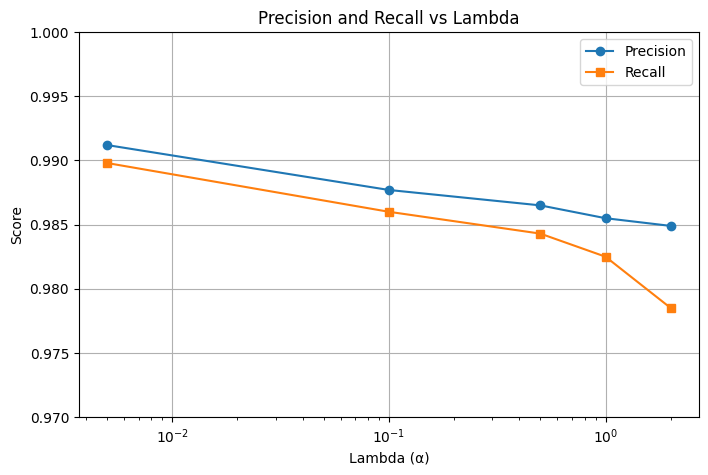

In [136]:
import matplotlib.pyplot as plt

# Data
lambdas = [2.0, 1.0, 0.5, 0.1, 0.005]
precisions = [0.9849, 0.9855, 0.9865, 0.9877, 0.9912]
recalls    = [0.9785, 0.9825, 0.9843, 0.9860, 0.9898]

# Plot
plt.figure(figsize=(8,5))
plt.plot(lambdas, precisions, marker="o", label="Precision")
plt.plot(lambdas, recalls, marker="s", label="Recall")

plt.xscale("log")   # log scale because lambdas shrink exponentially
plt.xlabel("Lambda (α)")
plt.ylabel("Score")
plt.title("Precision and Recall vs Lambda")
plt.ylim(0.97, 1.0)  # zoom into high range
plt.legend()
plt.grid(True)
plt.show()


In [126]:
λ = 1
def train_naive_bayes(messages, labels, alpha=1):
    vocab = set()
    spam_word_counts = Counter()
    ham_word_counts = Counter()
    spam_total = 0
    ham_total = 0
    spam_docs = 0
    ham_docs = 0

    # Tokenize and count
    for msg, label in zip(messages, labels):
        tokens = re.findall(r"[a-zA-Z]+", msg.lower())
        vocab.update(tokens)

        if label == "spam":
            spam_word_counts.update(tokens)
            spam_total += len(tokens)
            spam_docs += 1
        else:
            ham_word_counts.update(tokens)
            ham_total += len(tokens)
            ham_docs += 1

    total_docs = spam_docs + ham_docs
    priors = {
        "spam": spam_docs / total_docs,
        "ham": ham_docs / total_docs
    }

    return {
        "vocab": vocab,
        "spam_word_counts": spam_word_counts,
        "ham_word_counts": ham_word_counts,
        "spam_total": spam_total,
        "ham_total": ham_total,
        "priors": priors,
        "alpha": alpha
    }


In [127]:
def get_top_informative_words(model, top_n=200):
    vocab = model["vocab"] #model: dictionary containing your counts, vocab, etc.
    λ = model["alpha"]
    V = len(vocab)

    spam_counts = model["spam_word_counts"]
    ham_counts = model["ham_word_counts"]
    spam_total = model["spam_total"]
    ham_total = model["ham_total"]
    
    scores = {}
    for word in vocab:
        p_spam = (spam_counts.get(word, 0) + λ) / (spam_total + λ * V)
        p_ham  = (ham_counts.get(word, 0) + λ) / (ham_total + λ * V)
        score = abs(np.log(p_spam / p_ham))
        scores[word] = score
    
    top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return [w for w, _ in top_words]


In [128]:
def predict_nb(message, model, vocab=None):
    if vocab is None:
        vocab = model["vocab"]

    λ = model["alpha"]
    V = len(model["vocab"])  # smoothing denominator always uses full vocab
    spam_counts = model["spam_word_counts"]
    ham_counts = model["ham_word_counts"]
    spam_total = model["spam_total"]
    ham_total = model["ham_total"]

    log_prob_spam = 0
    log_prob_ham  = 0


    for word in message.split():
        if word not in vocab:
            continue
        p_spam = (spam_counts.get(word, 0) + λ) / (spam_total + λ * V)
        p_ham  = (ham_counts.get(word, 0) + λ) / (ham_total + λ * V)
        log_prob_spam += np.log(p_spam)
        log_prob_ham  += np.log(p_ham)

    return "spam" if log_prob_spam > log_prob_ham else "ham"


In [129]:
from sklearn.metrics import precision_score, recall_score

def evaluate(test_data, test_labels, model, top_words):
    preds = [predict_nb(msg, model, vocab=top_words) for msg in test_data]
    precision = precision_score(test_labels, preds, pos_label="spam")
    recall = recall_score(test_labels, preds, pos_label="spam")
    return precision, recall


In [130]:
# Example usage:
λ = 1
model = train_naive_bayes(X_train, y_train, alpha=λ)
top_words = get_top_informative_words(model, top_n=200)

precision, recall = evaluate(X_test, y_test, model, top_words)
print("Top 200 informative words:", top_words[:20])  # print sample
print("Precision:", precision)
print("Recall:", recall)

Top 200 informative words: ['lugnet', 'shopzilla', 'dcompacted', 'newbond', 'cert', 'bhttp', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'bnmzzs', 'pdfzone', 'rpcss', 'greylink', 'pnfs', 'hoodia', 'ephedra', 'patched', 'dmoney', 'node', 'vipcollectvip', 'anotherparty', 'writely']
Precision: 0.9974489795918368
Recall: 0.0784667870760586


In [134]:
# 1. Define classify function
def classify(message, model):
    tokens = re.findall(r"[a-zA-Z]+", message.lower())
    V = len(model["vocab"])
    alpha = model.get("alpha", 1.0)
    scores = {}

    for label in ["spam", "ham"]:
        scores[label] = math.log(model["priors"][label])

        if label == "spam":
            word_counts = model["spam_word_counts"]
            total_words = model["spam_total"]
        else:
            word_counts = model["ham_word_counts"]
            total_words = model["ham_total"]

        for token in tokens:
            token_count = word_counts.get(token, 0)
            prob = (token_count + alpha) / (total_words + alpha * V)
            scores[label] += math.log(prob)

    return max(scores, key=scores.get)   # ✅ RETURN a label



In [133]:
# 2. Test classify function
sample_msg = X_test.iloc[0]
print("Message:\n", sample_msg)
print("True label:", y_test.iloc[0])
print("Predicted:", classify(sample_msg, model))


Message:
 Received: from astron.Berkeley.EDU (astron [128.32.92.108])
	by chandra.berkeley.edu (Postfix) with ESMTP id 892DF78BC6;
	Thu, 20 Apr 2006 14:36:31 -0700 (PDT)
Received: from canaveral.indigo.cert.org (canaveral.indigo.cert.org [192.88.209.130])
	by astron.Berkeley.EDU (8.11.7/8.11.4) with SMTP id k3KLaU124310;
	Thu, 20 Apr 2006 14:36:30 -0700 (PDT)
Received: from canaveral.indigo.cert.org (localhost [127.0.0.1])
	by canaveral.indigo.cert.org (8.13.1/8.13.1/1.31) with ESMTP id k3JM3roW031669;
	Wed, 19 Apr 2006 18:03:53 -0400
Received: from localhost (lnchuser@localhost)
	by canaveral.indigo.cert.org (8.13.1/8.13.1/Submit/1.1) with SMTP id k3JJ8cKj023732;
	Wed, 19 Apr 2006 15:08:38 -0400
Date: Wed, 19 Apr 2006 15:08:38 -0400
Message-Id: <TA06-109A.4010@us-cert.gov>
From: US-CERT Technical Alerts <technical-alerts@us-cert.gov>
To: technical-alerts@us-cert.gov
Organization: US-CERT - +1 202-205-5266
List-Id: US-CERT Technical Alerts <technical-alerts.us-cert.gov>
List-Help: <htt